## Importing required packages

In [1]:
import dlib, cv2, pickle,os
import matplotlib.pyplot as plt
import numpy as np
from imutils.face_utils import FaceAligner
import inspect

# Defining Class for package

In [2]:
class FaceReco():
    
    ## Constructor for the package
    def __init__(self):
        self.faces = list()
        self.name = list()
        self.detector = dlib.get_frontal_face_detector()
        self.face_encoder = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')
        self.pose_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        self.fa = FaceAligner(self.pose_predictor)
        self.modelFile = "opencv_face_detector_uint8.pb"
        self.configFile = "opencv_face_detector.pbtxt"
        self.net = cv2.dnn.readNetFromTensorflow(self.modelFile, self.configFile)
        self.images = list()
    
    
    ## Method to detect face from image
    def faceDetection(self,im):
    
        img = cv2.imread(im)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        frameHeight = img.shape[0]
        frameWidth = img.shape[1]
        blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)
        self.net.setInput(blob)
        detections = self.net.forward()
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.7:
                x1 = int(detections[0, 0, i, 3] * frameWidth)
                y1 = int(detections[0, 0, i, 4] * frameHeight)
                x2 = int(detections[0, 0, i, 5] * frameWidth)
                y2 = int(detections[0, 0, i, 6] * frameHeight)
                faceAligned = self.fa.align(img, gray,dlib.rectangle(x1,y1,x2,y2))
                return faceAligned

            
    ## Method to recognize face when model is being trained
    def faceRecognitionTrainig(self, faceAligned):
        landmark = self.pose_predictor(faceAligned,dlib.rectangle(0,0,faceAligned.shape[0],faceAligned.shape[1]))
        face_descriptor = self.face_encoder.compute_face_descriptor(faceAligned, landmark, num_jitters=2)
        self.faces.append(face_descriptor)      
        return self.faces

    
    ## Method to recognize face when model is being tested
    def faceRecognitionTesting(self,faceAligned):
        landmark = self.pose_predictor(faceAligned,dlib.rectangle(0,0,faceAligned.shape[0],faceAligned.shape[1]))
        face_descriptor = self.face_encoder.compute_face_descriptor(faceAligned, landmark, num_jitters=2)
        score = np.linalg.norm(self.faces - np.array(face_descriptor), axis=1)
        imatches = np.argsort(score)
        score = score[imatches]
        return (self.name[imatches][:10].tolist())
    
    
    ## Method called by user for trainig of model
    ## Parameter accepted by user :  path of the folder which contains images for training
    def train_model(self,trainpath):
        for im in os.listdir(trainpath):
            faceAligned = self.faceDetection(os.path.join(trainpath,im))
            self.faces = self.faceRecognitionTrainig(faceAligned)
            self.name.append(im)
        self.faces = np.array(self.faces)
        self.name = np.array(self.name)
        np.save('face_repr.npy', self.faces)
        np.save('labels.npy', self.name)
        
    
    ## Method called by user for testing of the model
    ## Parameter : path of the given for testing
    ## return : list of the images
    def test_model(self,im):
        faceAligned = self.faceDetection(im)
        self.images = self.faceRecognitionTesting(faceAligned)
        return self.images
        
    
    

In [3]:
## Creating object of class FaceReco for training of Model
facereco = FaceReco() # creating instance
facereco.train_model("passport/faces") # calling method for training
im = "passport/face2/2709_10.jpg" 
images = facereco.test_model(im) # calling method for testing

passport/face2/2709_10.jpg
passport/faces\2709_9.jpg


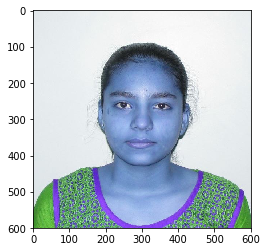

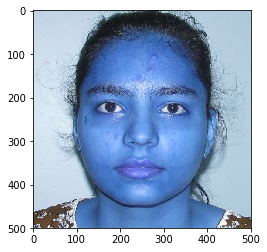

In [5]:
# validating the output
trainpath = "passport/faces"
plt.figure()
print(im)
plt.imshow(cv2.imread(im))
plt.figure()
print(os.path.join(trainpath,images[0]))
plt.imshow(cv2.imread(os.path.join(trainpath,images[0])))